# HackatOW Challenge: Customer Churn Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

## Data Loading

In [2]:
# client_info = pd.read_csv('./Data/client_info.csv')
# purchase_info = pd.read_csv('./Data/purchase_info.csv')
# city_info = pd.read_csv('./Data/city_info.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

client_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/client_info.csv")
purchase_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/purchase_info.csv")
city_info = pd.read_csv("/content/drive/My Drive/HackatOW/Data/city_info.csv")

print("Client Info:")
client_info.info()
print("\nPurchase Info:")
purchase_info.info()
print("\nCity Info:")
city_info.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Client Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10128 entries, 0 to 10127
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   user_id                          10128 non-null  object
 1   client_location                  10128 non-null  object
 2   activity                         9762 non-null   object
 3   marital                          9777 non-null   object
 4   tenure                           9791 non-null   object
 5   gender                           10128 non-null  object
 6   customer_satisfaction_score      9763 non-null   object
 7   customer_satisfaction_score_red  9749 non-null   object
 8   spending_to_lifetime             9754 non-null   object
 9   num_accounts                     9785 non-null   object
 10  OBS_DATE    

## Data Exploration


Client Info Describe:
            tenure  customer_satisfaction_score  \
count  9546.000000                  9527.000000   
mean    375.483868                  8797.391743   
min      12.000000                  6000.156943   
25%      46.000000                  7234.563211   
50%      71.000000                  8389.855275   
75%     106.000000                  9880.318057   
max    6420.000000                 14843.617741   
std     797.367744                  2026.674571   

       customer_satisfaction_score_red  spending_to_lifetime  num_accounts  \
count                      9527.000000           9546.000000   9516.000000   
mean                          3.518957              0.020943      1.291929   
min                           2.400063              0.000729      1.000000   
25%                           2.893825              0.007344      1.000000   
50%                           3.355942              0.012861      1.000000   
75%                           3.952127           

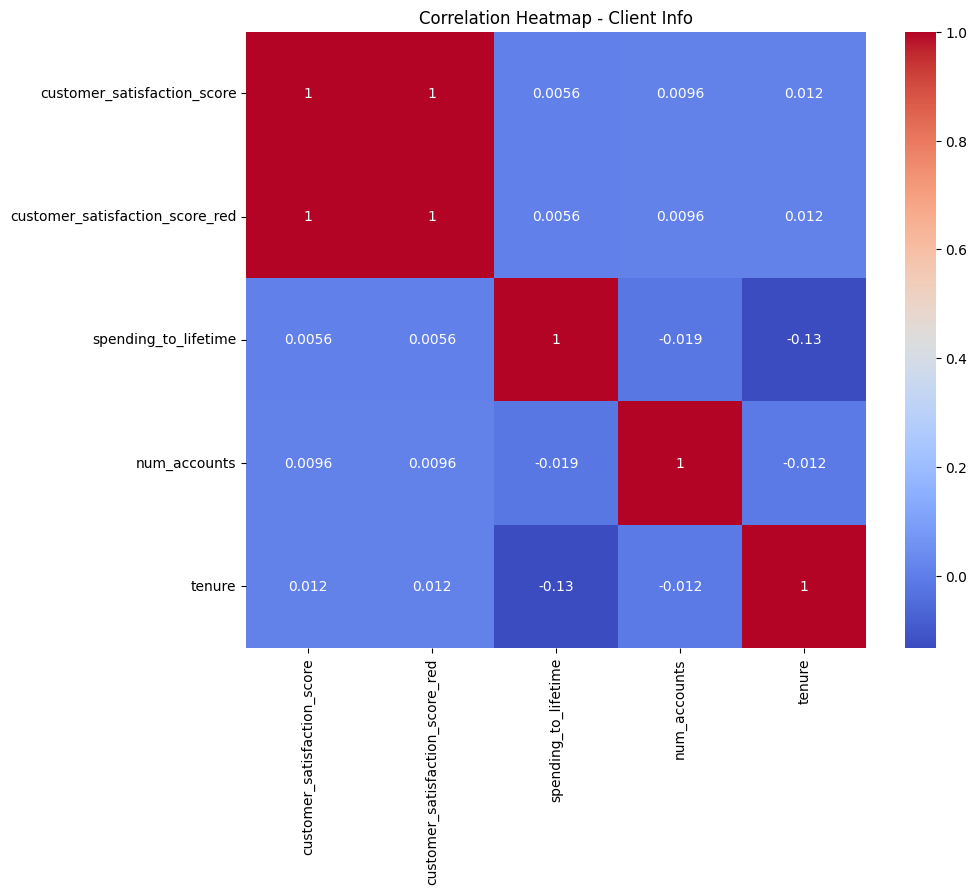

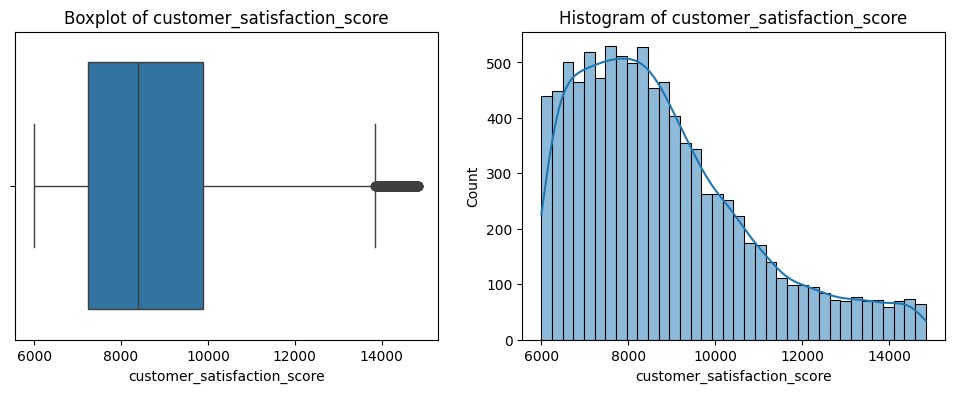

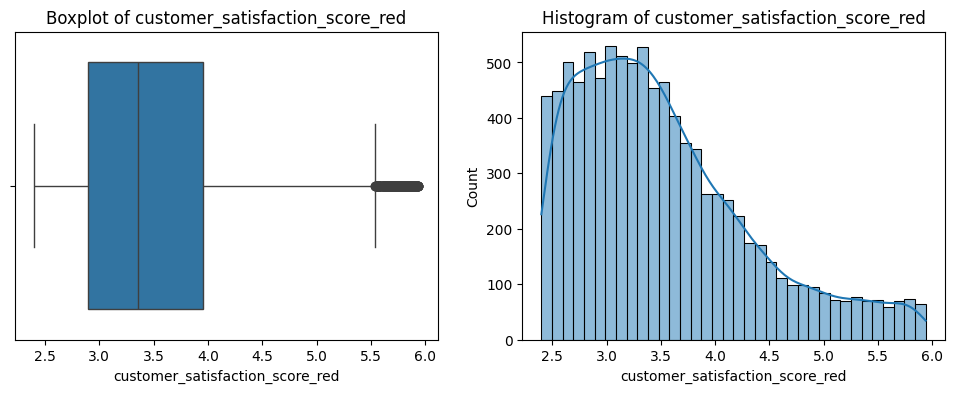

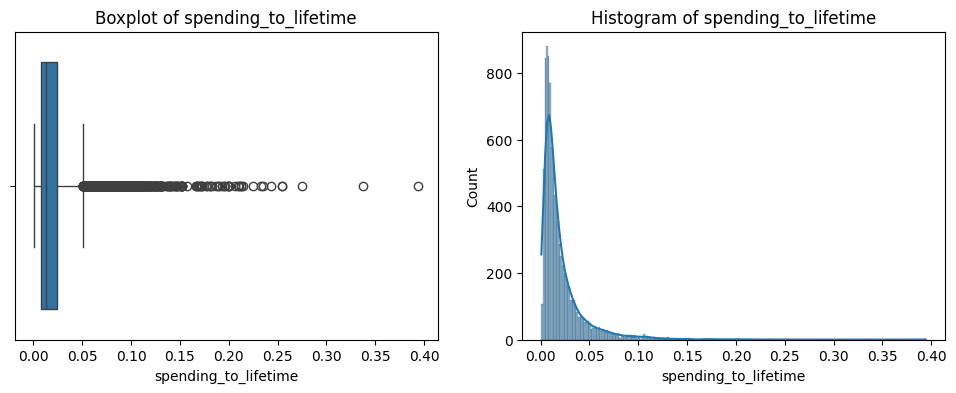

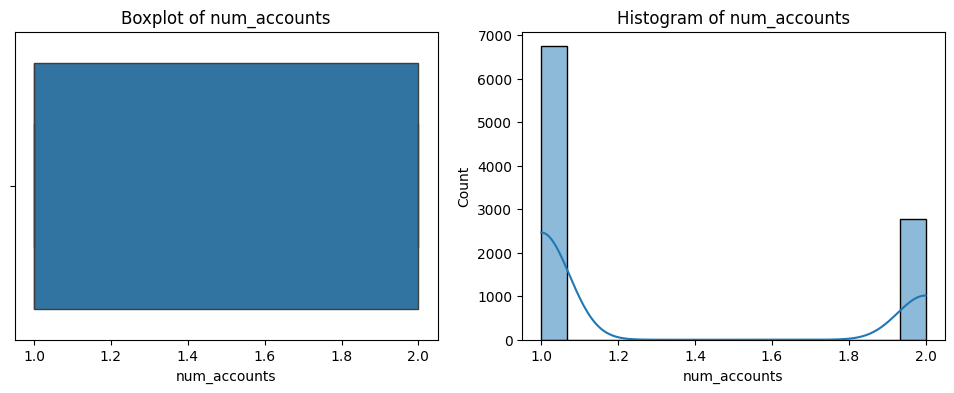

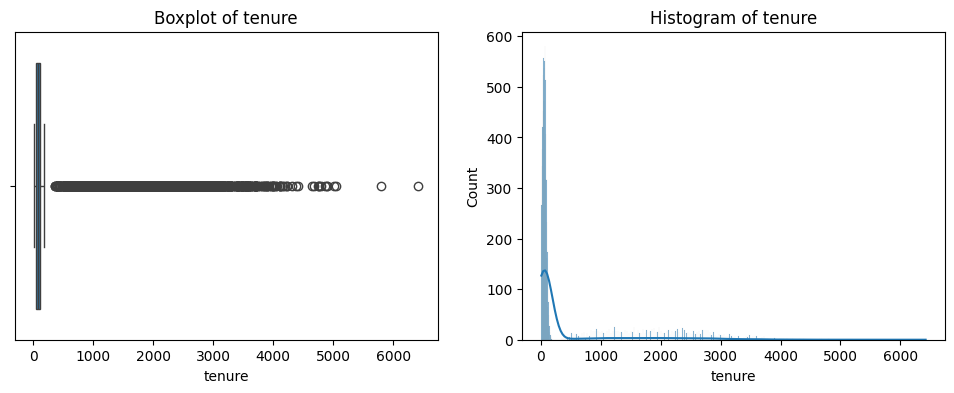

In [4]:
# Convert OBS_DATE to datetime
client_info['OBS_DATE'] = pd.to_datetime(client_info['OBS_DATE'], errors='coerce')

# Convert relevant numeric columns in client_info:
# (For instance, customer_satisfaction_score, spending_to_lifetime, num_accounts)
num_cols = ['customer_satisfaction_score', 'customer_satisfaction_score_red',
            'spending_to_lifetime', 'num_accounts', 'tenure']

for col in num_cols:
    client_info[col] = pd.to_numeric(client_info[col], errors='coerce')

# Display basic statistics
print("\nClient Info Describe:")
print(client_info.describe())

# Correlation heatmap for numeric variables in client_info
plt.figure(figsize=(10, 8))
corr = client_info[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Client Info")
plt.show()

# Boxplots and Histograms for key variables
for col in num_cols:
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    sns.boxplot(data=client_info, x=col)
    plt.title(f'Boxplot of {col}')

    plt.subplot(1,2,2)
    sns.histplot(client_info[col].dropna(), kde=True)
    plt.title(f'Histogram of {col}')

    plt.show()

## Data Preparation

In [5]:
# Merge datasets
# Merge client_info and purchase_info on 'user_id'
df = pd.merge(client_info, purchase_info, on='user_id', how='left')

# Merge city_info: assume client_info.client_location matches city_info.City
df = pd.merge(df, city_info, left_on='client_location', right_on='City', how='left')

# Drop redundant column
df.drop(columns=['City'], inplace=True)

# Handling missing values:
# For simplicity, we fill numeric columns with the median and categorical with mode.
numeric_features = ['customer_satisfaction_score', 'customer_satisfaction_score_red',
                    'spending_to_lifetime', 'num_accounts', 'tenure', 'total_spending', 'average_order_value']
categorical_features = ['client_location', 'activity', 'marital', 'gender', 'churn']

# Convert purchase_info numeric fields to numbers
# THESE ARE DUPLICATED
for col in ['total_spending', 'average_order_value']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute numeric features
num_imputer = SimpleImputer(strategy='median')
df[numeric_features] = num_imputer.fit_transform(df[numeric_features])

# Impute categorical features
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# Encode categorical variables using LabelEncoder (or consider OneHotEncoder for more granularity)
le = LabelEncoder()
for col in ['activity', 'marital', 'gender', 'churn', 'client_location']:
    df[col] = le.fit_transform(df[col])

# Feature Scaling for numeric features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Create training and OOT (Out-Of-Time) samples based on OBS_DATE.
# For example, OOT sample: year 2016-2018, training: others
df['year'] = df['OBS_DATE'].dt.year
oot_mask = df['year'].between(2016, 2018)
df_train = df[~oot_mask].copy()
df_oot = df[oot_mask].copy()

print(f"\nTraining sample size: {df_train.shape[0]}")
print(f"OOT sample size: {df_oot.shape[0]}")

# Define feature set X and target y (assuming 'churn' is our target)
features = numeric_features + ['activity', 'marital', 'gender', 'client_location', 'total_spending', 'average_order_value']
X_train = df_train[features]
y_train = df_train['churn'].astype(int)

X_test = df_oot[features]
y_test = df_oot['churn'].astype(int)


Training sample size: 9732
OOT sample size: 3433


## Model Training & Evaluation

In [6]:
# Baseline Model: Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Additional Models

# 1. Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# 2. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
print("\nGradient Boosting Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

# 3. XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Logistic Regression Evaluation:
Accuracy: 0.8657151179726187
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      2881
           1       0.64      0.40      0.49       475
           2       0.00      0.00      0.00        77

    accuracy                           0.87      3433
   macro avg       0.51      0.45      0.47      3433
weighted avg       0.83      0.87      0.84      3433



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Evaluation:
Accuracy: 0.8718322167200699
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2881
           1       0.66      0.45      0.53       475
           2       0.00      0.00      0.00        77

    accuracy                           0.87      3433
   macro avg       0.52      0.47      0.49      3433
weighted avg       0.84      0.87      0.85      3433



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting Evaluation:
Accuracy: 0.8762015729682493
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2881
           1       0.67      0.51      0.58       475
           2       0.00      0.00      0.00        77

    accuracy                           0.88      3433
   macro avg       0.52      0.49      0.50      3433
weighted avg       0.85      0.88      0.86      3433



AttributeError: 'DataFrame' object has no attribute 'dtype'